In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy 
from spacy import displacy
from spacy import tokenizer

import re

import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel 
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report


In [114]:
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = '#00bfbf'

In [115]:
data = pd.read_csv(r'D:\Personal_Projects\ai-bootcamp\section_27_Fake_News_Case_Study\fake_news_data.csv')

In [116]:
data.head(10)

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News


Text(0.5, 1.0, 'Count of Article Classification')

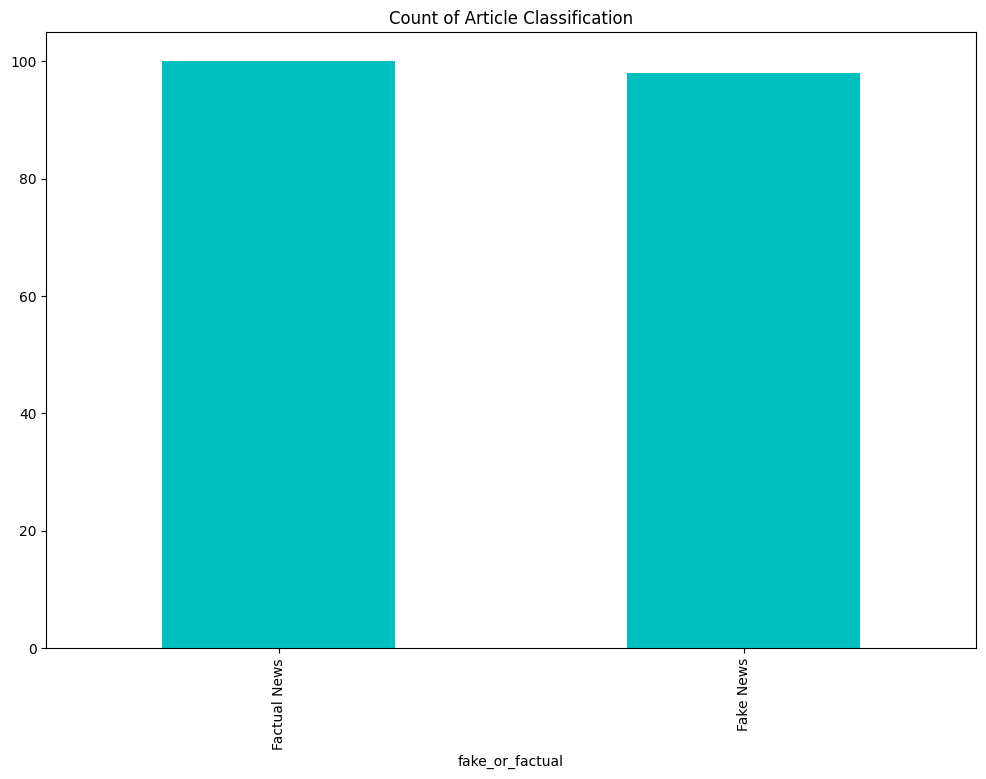

In [117]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Count of Article Classification')

# POS Tagging

In [118]:
nlp = spacy.load('en_core_web_sm')

In [119]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
factual_news = data[data['fake_or_factual'] == 'Factual News']

In [120]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(factual_news['text']))

KeyboardInterrupt: 

In [ ]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [ ]:
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

In [ ]:
for doc in fake_spacydocs:
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [ ]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [ ]:
fake_tagsdf

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
...,...,...,...
743,.,,PUNCT
744,Via,,PROPN
745,:,,PUNCT
746,Campus,PERSON,PROPN


In [ ]:
fact_tagsdf = []

for doc in fact_spacydocs:
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)


In [ ]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [ ]:
fact_tagsdf

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
...,...,...,...
85,citing,,VERB
86,three,CARDINAL,NUM
87,unnamed,,ADJ
88,officials,,NOUN


In [ ]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [ ]:
pos_counts_fake

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
...,...,...,...
3770,detectives,VERB,1
3769,detective,NOUN,1
3768,detained,VERB,1
3766,detail,NOUN,1


In [122]:
pos_counts_factual = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [121]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
DET        42
INTJ       24
PUNCT      23
CCONJ      19
X          14
PART       10
SYM         5
SPACE       3
Name: token, dtype: int64

In [123]:
pos_counts_factual.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
DET        36
PUNCT      22
SPACE      11
CCONJ      11
X          10
INTJ        7
PART        7
SYM         4
Name: token, dtype: int64

In [ ]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
...,...,...,...
3781,developments,NOUN,1
3778,devastation,NOUN,1
3772,determination,NOUN,1
3769,detective,NOUN,1


In [125]:
pos_counts_factual[pos_counts_factual.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42
